Using TensorFlow backend.
W0904 21:01:33.479329 140631944402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 21:01:33.480549 140631944402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 21:01:33.493928 140631944402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 21:01:33.534468 140631944402816 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 

Found 30000 images belonging to 1 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/2000] [Batch 1/3750] [D loss: 8.567158, acc:  15%] [G loss: 83.341904] time: 0:00:13.040612


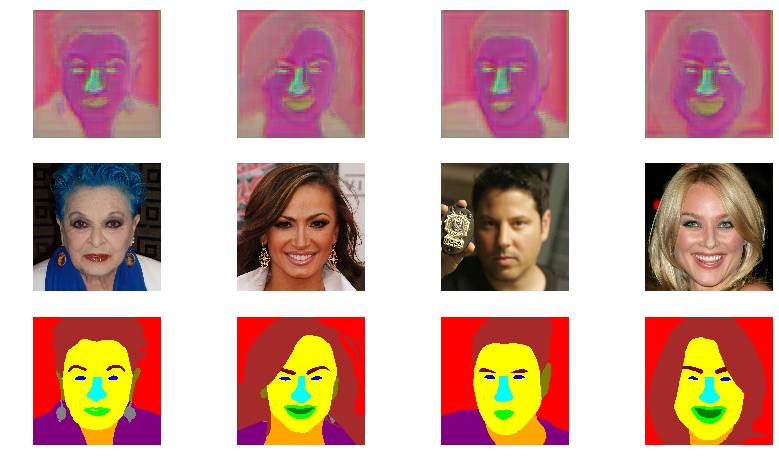

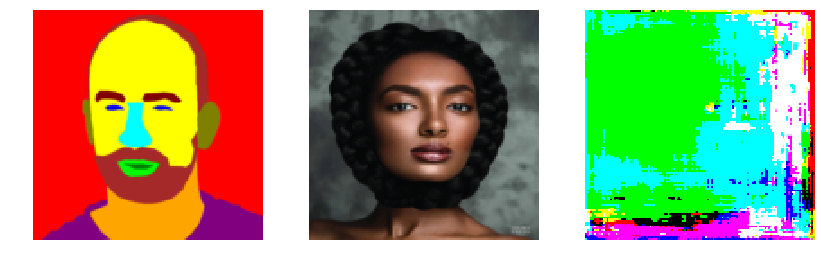

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/2000] [Batch 1001/3750] [D loss: 0.089479, acc:  92%] [G loss: 27.881180] time: 0:08:12.463624


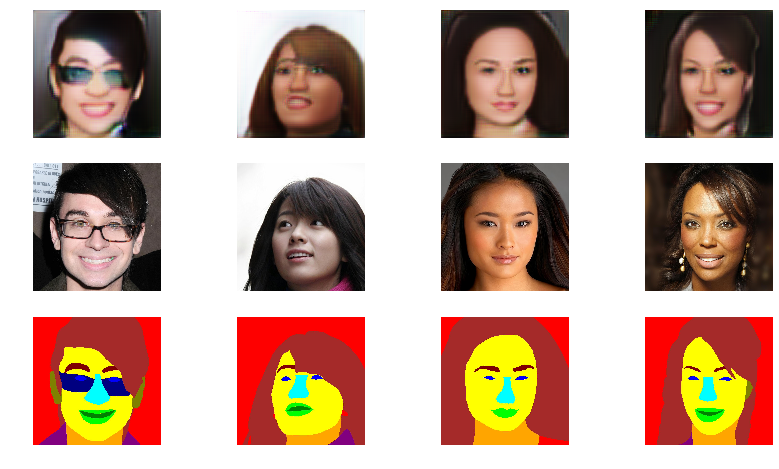

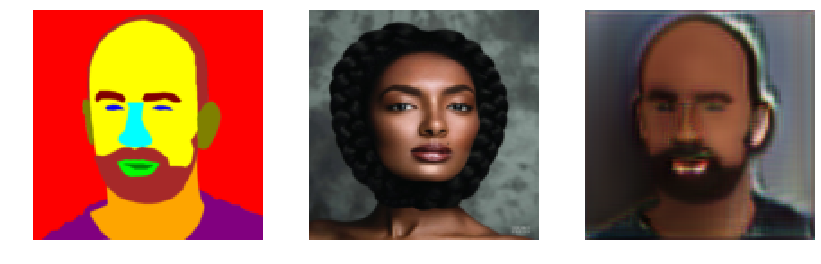

[Epoch 0/2000] [Batch 2001/3750] [D loss: 0.061068, acc:  98%] [G loss: 22.586454] time: 0:16:12.993299


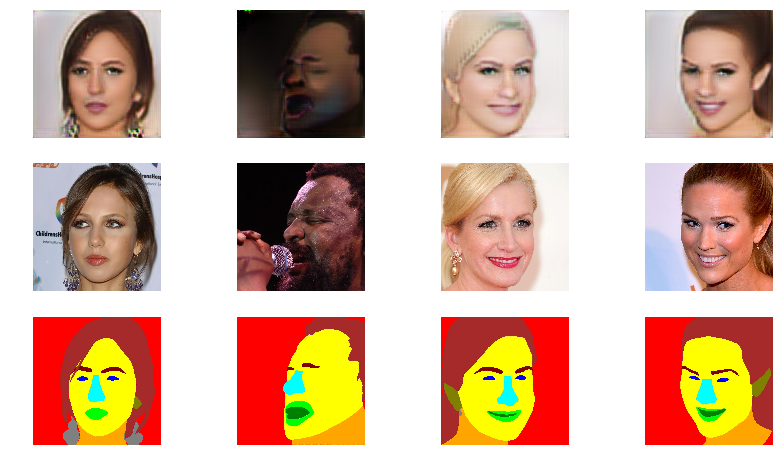

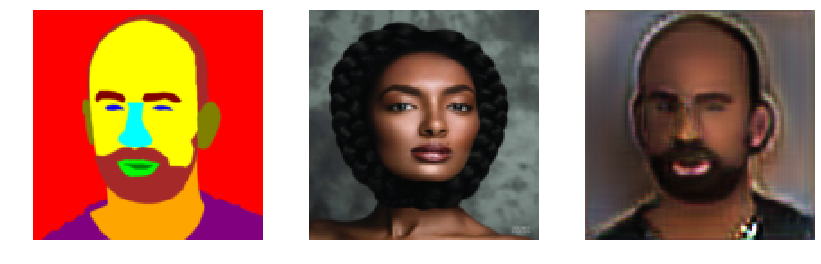

KeyboardInterrupt: ignored

In [0]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Add, multiply, Reshape, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os, sys, random
import tensorflow as tf
from keras import backend as K


rows = 128
cols = 128
batch_checkpoint = 1000

# Mix GRAM Matrix with embeddings (Do not reference self in lambda)
def mix_embeddings_with_gram(embedding_img, embedding_feat):
    assert len(embedding_img.shape) > 3
    assert len(embedding_img.shape) == len(embedding_feat.shape)
    assert embedding_img.shape[1:] == embedding_feat.shape[1:]
    
    # Maybe a redundant check with the last one here, but do not bother
    for i in range(len(embedding_img.shape)-1):
        assert embedding_img.shape[i+1] == embedding_feat.shape[i+1]
    
    final_shape = embedding_img.shape[1:]
    filters = embedding_img.shape[-1]
    w_h = np.prod(embedding_img.shape[1:-1])
    
    features = K.reshape(embedding_feat, (-1, w_h, filters))
    transpose = K.transpose(features)
    transpose = K.permute_dimensions(transpose, (2, 0, 1))
    gram = K.batch_dot(transpose, features)

    # Multiply gram with embedding img
    embedding_img = K.reshape(embedding_img, (-1, w_h, filters))
    latent = K.batch_dot(embedding_img, gram)
    latent = Reshape(final_shape.as_list())(latent)
    return latent

class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'DATASET_HIRES/'
#         self.dataset_name = 'facades/'


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4), int(self.img_cols / 2**4)
        self.disc_patch = (patch[0], patch[1], 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_feat = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator([img_B, img_feat])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_feat, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
        
    def show_imgs(self, img_batch, epoch, batch_i, dLoss, dAcc, gLoss, use_tree_rows=True):
        if not os.path.exists('IMG'):
            os.makedirs('IMG')
            
        if (len(img_batch) % 3 == 0 and use_tree_rows):
            plot_width = int(len(img_batch)/3)
            fig, axs = plt.subplots(3, plot_width, figsize=(14, 8))
            for i in range (3):
                for j in range(plot_width):
                    img = np.asarray((img_batch[(i*plot_width)+j]+1)*127.5, np.uint8)
                    axs[i, j].imshow(img)
                    axs[i, j].axis('off')
                
        else:
            fig, axs = plt.subplots(1, len(img_batch), figsize=(14, 8))
            for i in range(int(len(img_batch))):
                img = np.asarray((img_batch[i]+1)*127.5, np.uint8)
                axs[i].imshow(img)
                axs[i].axis('off')
            
        imgname = "IMG/"+"img_"+str(epoch).zfill(6)+"_"+str(batch_i)+"_"+str(dLoss)+"_"+str(dAcc)+"_"+str(gLoss)+".png"
        fig.savefig(imgname)
        plt.show()
        plt.close()
        
    def show_test_image(self, test_image_path, img_feat_path, epoch):
        imgs_test = []
        im = Image.open(test_image_path)
        image_test = np.array(im.resize((self.img_cols,self.img_rows), Image.BILINEAR))
        image_test = np.asarray(image_test/127.5 - 1)
        
        imgs_feat = []
        im = Image.open(img_feat_path)
        image_feat = np.array(im.resize((self.img_cols,self.img_rows), Image.BILINEAR))
        image_feat = np.asarray(image_feat/127.5 - 1)
        
        image_test_in = image_test.reshape(1, self.img_rows,self.img_cols,self.channels)
        image_feat_in = image_feat.reshape(1, self.img_rows,self.img_cols,self.channels)
        prediction = self.generator.predict([image_test_in, image_feat_in])
        imgs_test.append(image_test)
        imgs_test.append(image_feat)
        imgs_test.append(prediction[0])
        
        self.show_imgs(imgs_test, epoch, 0, 0, 0, 0, use_tree_rows=False)
        img = Image.fromarray(np.asarray((prediction[0]+1)*127.5, np.uint8))
        img.save("IMG/"+str(epoch).zfill(6)+".png")
        
    def checkpoint(self, epoch, epochs, batch_i, num_batches, imgs_A, imgs_B, fake_A, dLoss, dAcc, gLoss, elapsed_time):
        self.save(epoch)
        
        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs, batch_i+1,
                                                                                                   num_batches, dLoss, 
                                                                                                   dAcc, gLoss, 
                                                                                                   elapsed_time))
        length = 4 if len(fake_A) >= 4 else len(fake_A)
        if length == 1:
            length = 2
            imgs_A.append(imgs_A[0])
            fake_A.append(fake_A[0])
            # imgs_B[0:length],
        
        finalArr = np.concatenate((fake_A[0:length], imgs_A[0:length], imgs_B[0:length]), axis=0)
        self.show_imgs(finalArr, epoch, batch_i, dLoss, dAcc, gLoss)
        self.show_test_image('pruebadot_s.jpg', 'prueba_.jpg', epoch)
        sys.stdout.flush()
        
    def save(self, epoch):
        if not os.path.exists('MODELS'):
            os.makedirs('MODELS')
        self.generator.save('MODELS/generator_'+ str(epoch) +'.h5')
        self.discriminator.save('MODELS/discriminator_'+ str(epoch) +'.h5')
        
    def load(self, epoch, load_discriminator = True):
        self.generator.load_weights('MODELS/generator_'+ str(epoch) +'.h5')
        if (load_discriminator):
            self.discriminator.load_weights('MODELS/discriminator_'+ str(epoch) +'.h5')
    
    def gram_matrix(self, x):
        features = K.reshape(x, (-1, 6, 512))
        transpose = K.transpose(features)
        transpose = K.permute_dimensions(transpose, (2, 0, 1))
        gram = K.batch_dot(transpose, features)
        return gram

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True, reset_filters=True):
            """Layers used during downsampling"""
            d_src = AveragePooling2D(pool_size=(2, 2))(layer_input)
            if reset_filters:
                d_src = Conv2D(filters, kernel_size=1, strides=1, padding='same')(d_src)
            d = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(d_src)
            d = LeakyReLU(alpha=0.2)(d)
            d = Add()([d, d_src])
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)
        feat0 = Input(shape=self.img_shape)

        # Downsampling Input segmentation
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8, reset_filters=False)
        d6 = conv2d(d5, self.gf*8, reset_filters=False)
        d7 = conv2d(d6, self.gf*8, reset_filters=False)
        
        # Downsampling Feature Image
        feat1 = conv2d(feat0, self.gf, bn=False)
        feat2 = conv2d(feat1, self.gf*2)
        feat3 = conv2d(feat2, self.gf*4)
        feat4 = conv2d(feat3, self.gf*8)
        feat5 = conv2d(feat4, self.gf*8, reset_filters=False)
        feat6 = conv2d(feat5, self.gf*8, reset_filters=False)
        feat7 = conv2d(feat6, self.gf*8, reset_filters=False)
        
        latent = Lambda(lambda x: mix_embeddings_with_gram(x[0], x[1]))([d7,feat7])

        # Upsampling
        u1 = deconv2d(latent, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model([d0, feat0], output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        datagen = ImageDataGenerator(rescale = 1. / 127.5)
        data_generator = datagen.flow_from_directory(
            self.dataset_name,
            target_size=(self.img_rows, self.img_cols*2),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=True)
        num_batches = int(len(data_generator.filenames) / batch_size)

        for epoch in range(epochs):
            for batch_i in range (num_batches):
                imgs = data_generator.next()[0]
                h, w, _ = imgs[0].shape
                _w = int(w/2)
                
                imgs_A = []
                imgs_B = []
                imgs_Feat = []
                for img in imgs:
                    img_A, img_B = img[:, :_w, :], img[:, _w:, :]
                  
                    # Change this for B to A
                    imgs_A.append(img_A)
                    imgs_B.append(img_B)
                    imgs_Feat.append(img_A)

                imgs_A = np.array(imgs_A) - 1.
                imgs_B = np.array(imgs_B) - 1.
                imgs_Feat = np.array(imgs_Feat) - 1.
                
                if len(valid) != len(imgs_A):
                    valid = np.ones((len(imgs_A),) + self.disc_patch)
                    fake = np.zeros((len(imgs_A),) + self.disc_patch)
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict([imgs_B, imgs_Feat])

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A,  imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_Feat, imgs_B], [valid, imgs_A])
                elapsed_time = datetime.datetime.now() - start_time
                
                if (batch_checkpoint > 0 and batch_i % batch_checkpoint == 0):
                    self.checkpoint(epoch, epochs, batch_i, num_batches, imgs_A, imgs_B, fake_A, 
                                    d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time)

#                 # If at save interval => save generated image samples
#                 if epoch % sample_interval == 0 and batch_i == 0:
#                     self.checkpoint(epoch, epochs, batch_i, num_batches, imgs_A, imgs_B, fake_A, 
#                                     d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time)
                
    
gan = Pix2Pix()
# gan.load(60)
gan.train(epochs=2000, batch_size=8, sample_interval=20)
gan.save(2000)

Loading pix2pix model: ./generator.h5..
Loading model.. DONE!


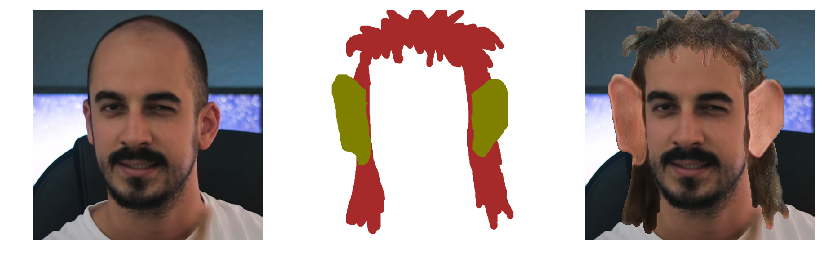

In [3]:
# COONFIGURATION CLASS
class P:
  BASE_DIR = "./"
  PIX2PIX_MODEL = "generator.h5"
  TEMP_DIR = "temp"
  SAVE_PIX2PIX_DATA = True
  
  SEGMENT_PARTIAL = "pruebadot_sm.jpg"
  SEGMENT_FULL = "pruebadot_s.jpg"
  BASE_IMG = "pruebadot_f.jpg"
  PIX2PIX_SIZE = (512, 512)
  
  channels = 3
  gf = 64
  img_shape = (512, 512, channels)

# ACTUALLY TESTING THE FINAL MODEL PROCESS:
## WITHOUT GRAM ##
from __future__ import print_function, division

# KERAS
from keras.models import load_model
from keras import backend as K
from keras.layers import *
from keras.models import Model

import tensorflow as tf
from keras.models import load_model
import base64, uuid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print("Loading pix2pix model: " + P.BASE_DIR + P.PIX2PIX_MODEL + "..")
pix2pix = build_generator()
pix2pix.load_weights(P.BASE_DIR + P.PIX2PIX_MODEL)
print("Loading model.. DONE!")

# WHITE BACKGROUND + PAINT CAUSE IT IS RGBA AND WE NEED ONLY RGB
segment_partial = Image.open(P.BASE_DIR + P.SEGMENT_PARTIAL).resize(P.PIX2PIX_SIZE, Image.BILINEAR)
segment_full = Image.open(P.BASE_DIR + P.SEGMENT_FULL).resize(P.PIX2PIX_SIZE, Image.BILINEAR)
features = Image.open(P.BASE_DIR + P.BASE_IMG).resize(P.PIX2PIX_SIZE, Image.BILINEAR)

# CREATE THE MASK
fn = lambda x : 0 if x > 200 else 255
mask = segment_partial.convert('L').point(fn, mode='1')

segment_full.paste(segment_partial, mask=mask)

## PREPARE IMAGE FOR MODEL INGESTION
img_seg = np.array(segment_full.resize(P.PIX2PIX_SIZE, Image.BILINEAR))
img_seg = np.asarray(img_seg/127.5 - 1)
img_seg = np.expand_dims(img_seg, axis=0)

final_img = features.resize(P.PIX2PIX_SIZE, Image.BILINEAR)
img_feat = np.array(final_img)
img_feat = np.asarray(img_feat/127.5 - 1)
img_feat = np.expand_dims(img_feat, axis=0)

# DO THE MAGIC
out = pix2pix.predict(img_seg)
out_img = Image.fromarray(np.uint8((out[0]+1)*127.5))
final_img.paste(out_img, mask=mask)
final_img.save("final.jpg")

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
axs[0].imshow(features)
axs[0].axis('off')
axs[1].imshow(segment_partial)
axs[1].axis('off')
axs[2].imshow(final_img)
axs[2].axis('off')
plt.show()
plt.close()